<a href="https://colab.research.google.com/github/Ayuniarfina/Final-Project-Bangkit---JKT4-B/blob/master/improvedmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Improved model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import zipfile
zipref = zipfile.ZipFile('/content/gdrive/My Drive/Data Colab/faceexp.zip')
zipref.extractall('/tmp/dataset')

In [3]:
import tensorflow as tf
import collections
import matplotlib.pyplot as plt

In [4]:
import shutil
#shutil.rmtree('/tmp/dataset')
shutil.rmtree('/tmp/dataset/images/images/train/neutral')
shutil.rmtree('/tmp/dataset/images/images/validation/neutral')

In [13]:
train_dir = ('/tmp/dataset/images/images/train')
test_dir = ('/tmp/dataset/images/images/validation')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
  #rotation_range=40,
  #width_shift_range=0.2,
  #height_shift_range=0.2,
  horizontal_flip=True,
  #fill_mode='nearest' 
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

traingenerator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

testgenerator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='categorical',
    shuffle=False
)

Found 23839 images belonging to 6 classes.
Found 5850 images belonging to 6 classes.


In [14]:
print (traingenerator.class_indices)

labels = '\n'.join(sorted(traingenerator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5}


In [15]:
!cat labels.txt

angry
disgust
fear
happy
sad
surprise

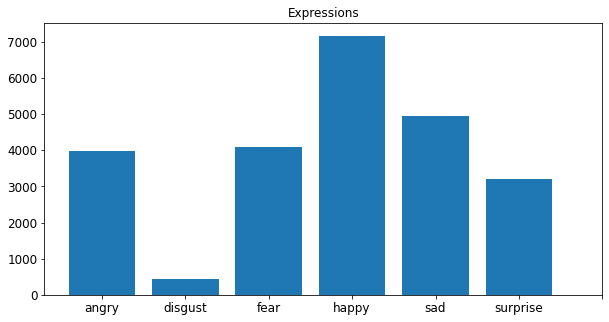

 
Counter({3: 7164, 4: 4938, 2: 4103, 0: 3993, 5: 3205, 1: 436})


In [16]:
trainset = collections.Counter(traingenerator.classes)
plt.figure(figsize=(10,5))
plt.bar(trainset.keys(), trainset.values())
xlabel = ['angry','disgust','fear','happy','sad','surprise']
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=xlabel)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.title('Expressions')
plt.show()
print(' ')
print(trainset)

In [17]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top= False,
    weights= 'imagenet',
    input_shape= (150,150,3)
)

for layer in pre_trained_model.layers:
  layer.trainable = False

#pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = tf.keras.layers.Flatten()(last_output)
x= tf.keras.layers.Dense(128, activation='relu')(x)
x= tf.keras.layers.Dropout(0.25)(x)
x= tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(pre_trained_model.input,x)
#model.summary()

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(traingenerator, epochs=5, validation_data=testgenerator)

Epoch 1/5
745/745 [==============================] - 63s 85ms/step - loss: 1.2450 - acc: 0.5131 - val_loss: 1.0764 - val_acc: 0.5692
Epoch 2/5
745/745 [==============================] - 62s 83ms/step - loss: 1.0627 - acc: 0.5778 - val_loss: 1.0184 - val_acc: 0.6077
Epoch 3/5
745/745 [==============================] - 62s 83ms/step - loss: 0.9849 - acc: 0.6114 - val_loss: 1.0096 - val_acc: 0.6079
Epoch 4/5
745/745 [==============================] - 62s 83ms/step - loss: 0.9189 - acc: 0.6384 - val_loss: 0.9711 - val_acc: 0.6277
Epoch 5/5
745/745 [==============================] - 62s 83ms/step - loss: 0.8648 - acc: 0.6559 - val_loss: 0.9793 - val_acc: 0.6267


In [19]:
#Fine Tune Model
for layer in pre_trained_model.layers:
  layer.trainable = True

print('Number of layers: ', len(pre_trained_model.layers))

fine_tune_at = 200

for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers:  311


In [20]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss='categorical_crossentropy', metrics=['acc'])
history_refined = model.fit_generator(traingenerator, epochs=8,initial_epoch= history.epoch[-1], validation_data=testgenerator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 5/8
745/745 [==============================] - 76s 102ms/step - loss: 0.8388 - acc: 0.6695 - val_loss: 0.9476 - val_acc: 0.6506
Epoch 6/8
745/745 [==============================] - 75s 101ms/step - loss: 0.7311 - acc: 0.7153 - val_loss: 0.9450 - val_acc: 0.6542
Epoch 7/8
745/745 [==============================] - 75s 101ms/step - loss: 0.6510 - acc: 0.7455 - val_loss: 0.9656 - val_acc: 0.6646
Epoch 8/8
745/745 [==============================] - 75s 101ms/step - loss: 0.5791 - acc: 0.7783 - val_loss: 0.9817 - val_acc: 0.6696


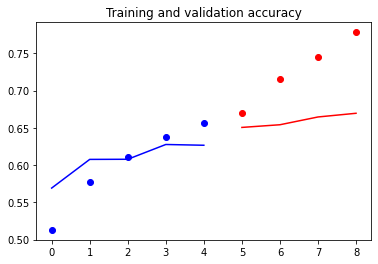

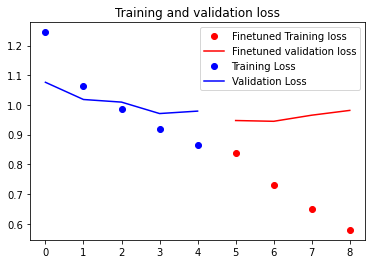

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
refined_val_acc=history_refined.history['val_acc']
refined_acc=history_refined.history['acc']
refined_val_loss=history_refined.history['val_loss']
refined_loss=history_refined.history['loss']

epochsrefined = [5,6,7,8]
epochs = range(len(acc))

plt.plot(epochsrefined, refined_acc,'ro', label='Finetuned Training accuracy')
plt.plot(epochsrefined, refined_val_acc,'r', label='Finetuned validation accuracy')
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()


plt.plot(epochsrefined, refined_loss,'ro', label='Finetuned Training loss')
plt.plot(epochsrefined, refined_val_loss,'r', label='Finetuned validation loss')
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.plot(figsize=(10,5))
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
# Evaluate Model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random

In [26]:
# Using test generator dataset
Y_pred = model.predict(testgenerator)
y_pred = np.argmax(Y_pred, axis=1)

actual = collections.Counter(testgenerator.classes)
prediction = collections.Counter(y_pred)

X = ['angry','disgust','fear','happy','sad','surprise']
Y=[]
Z=[]

for i in range(len(xlabel)):
  Y.append(actual[i])
  Z.append(prediction[i])

In [27]:
print('actual:',actual)
print('prediction:',prediction)

actual: Counter({3: 1825, 4: 1139, 2: 1018, 0: 960, 5: 797, 1: 111})
prediction: Counter({3: 1944, 4: 1166, 2: 1061, 0: 964, 5: 665, 1: 50})


In [28]:
# Plot Random N Missclassified Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tes1 = testgenerator.classes
tes2 = y_pred
diff = tes1-tes2

In [29]:
#Initiatialize
x=[]
y=0
labels = ['angry','disgust','fear','happy','sad','surprise']
#Calculate False Prediction Location (x)
for i in range(len(diff)):
  if diff[i]>0 or diff[i]<0:
    x.append(i)
    y+=1

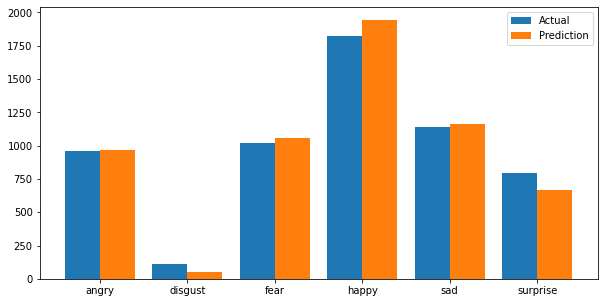

In [30]:
def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    plt.figure(figsize=(10,5))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.legend(['Actual', 'Prediction'])
    plt.xticks(_X, X)
    
subcategorybar(X, [Y,Z])

plt.show()

Total Images:  5850
Number of Images Missclassified:  1933
 


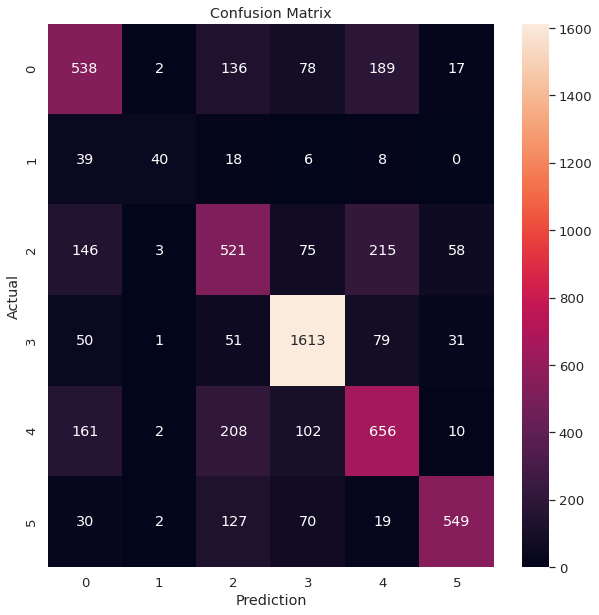

In [34]:
import seaborn as sn
import pandas as pd

print('Total Images: ',len(tes1))
print('Number of Images Missclassified: ',y)
print(' ')


array= confusion_matrix(testgenerator.classes,y_pred)

plt.subplots(figsize=(10,10))
df_cm=pd.DataFrame(array, range(6),range(6))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [33]:
# Classification Report

target_names = ['angry','disgust','fear','happy','sad','surprise']
print(classification_report(testgenerator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.56      0.56      0.56       960
     disgust       0.80      0.36      0.50       111
        fear       0.49      0.51      0.50      1018
       happy       0.83      0.88      0.86      1825
         sad       0.56      0.58      0.57      1139
    surprise       0.83      0.69      0.75       797

    accuracy                           0.67      5850
   macro avg       0.68      0.60      0.62      5850
weighted avg       0.67      0.67      0.67      5850



In [ ]:
#Print N Random Misclassified Images (limit==N)
limit=0
dir = ('/tmp/dataset/images/images/validation')
while True:
  limit+=1
  nomor = random.sample(x,1)
  print(#testgenerator.filenames[(nomor[0])],
        'actual:', labels[tes1[(nomor[0])]], '/ prediction:', labels[tes2[(nomor[0])]])
  plt.imshow(mpimg.imread(dir+'/'+testgenerator.filenames[(nomor[0])]))
  plt.show()

  if limit == 20:
    break

In [ ]:
basedir = ('/tmp/dataset/images/images/validation/')
expression = ('sad')
nsample = 25
import os
listname = os.listdir(basedir+expression)
test = random.sample(listname, nsample)
tests=0
for i in test:
  plt.subplots(figsize=(4,4))
  dir = basedir+expression+'/'+i
  plt.imshow(mpimg.imread(dir),cmap='gray')
plt.show()

In [ ]:
#Save Model
#saved_model_dir = 'save/fine_tuning'
#tf.saved_model.save(model, saved_model_dir)

#converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
#tflite_model = converter.convert()

#with open('model.tflite', 'wb') as f:
#  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
#from google.colab import files

#files.download('model.tflite')
#files.download('labels.txt')

In [11]:
tf.keras.backend.clear_session()

In [12]:
del history